In [221]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence, load_img, img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import random


# Draw Landmarks on Image
Can be used with images or live feed.

In [173]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

# noinspection PyShadowingNames
def draw_landmarks(current_frame, landmarker_result):
  hand_landmarks_list = landmarker_result.hand_landmarks
  handedness_list = landmarker_result.handedness
  annotated_image = np.copy(current_frame)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_protocol = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_protocol.landmark.extend([
    # Normalize the coordinates
      landmark_pb2.NormalizedLandmark(
          x=landmark.x, 
          y=landmark.y, 
          z=landmark.z) for landmark in hand_landmarks])
    
    # Draw the landmarks
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_protocol,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN
    
    # Draw bounding box
    xmin, xmax = int(min(x_coordinates) * width), int(max(x_coordinates) * width)
    ymin, ymax = int(min(y_coordinates) * height), int(max(y_coordinates) * height)
    boxW, boxH = xmax - xmin, ymax - ymin
    cv2.rectangle(annotated_image, 
                 pt1=(xmin - 20, ymin - 20), pt2=(xmin + boxW + 20, ymin + boxH + 20), 
                 color=(0, 0, 255), thickness=2)
    
    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}", (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX, FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)
               
  return annotated_image

model_path = 'hand_landmarker.task'
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the image mode:
options = HandLandmarkerOptions(base_options=BaseOptions(model_asset_path=model_path), running_mode=VisionRunningMode.IMAGE, num_hands=1)
HandLandmarker = vision.HandLandmarker.create_from_options(options)

# Custom Image Generator
To only take a number of samples to include in the dataset.

In [174]:
class CustomPreprocessImage(Sequence):
    def __init__(self, directory, classes, images_per_class, split, target_size=(150, 150), batch_size=32, remove_images=dict()):
        self.directory = directory
        self.classes = classes
        self.images_per_class = images_per_class
        self.target_size = target_size
        self.batch_size = batch_size
        self.filepaths = []
        self.labels = []
        self.handlandmarks = []
        self.split = split
        self.selected_images = dict()
        self.remove_images = remove_images
        self._initialize()
        
    def _initialize(self):
        for class_name in self.classes:
            class_dir = os.path.join(self.directory, class_name)
            class_image_files = os.listdir(class_dir)
            class_index = self.classes.index(class_name)
           
            if self.remove_images and self.remove_images[class_index]:
                class_image_files = list(set(class_image_files).difference(self.remove_images[class_index]))
                
            np.random.shuffle(class_image_files)
            if self.images_per_class == 0:
                return
            if 0.0 < self.images_per_class and self.images_per_class <= 1.0:
                self.images_per_class = int(self.images_per_class * len(class_image_files))
                
            if self.images_per_class <= len(class_image_files):
                self.selected_images[class_index] = class_image_files[:self.images_per_class]
            else:
                self.selected_images[class_index] = class_image_files
                    
            for img_name in self.selected_images[class_index]:
                img_path = os.path.join(class_dir, img_name)
                
                # Generate Hand Landmark Data for Image
                image = mp.Image.create_from_file(img_path)
                detection_result = HandLandmarker.detect(image)
                
                self.filepaths.append(img_path)
                self.handlandmarks.append(detection_result)
                self.labels.append(class_index)
        
    #    self.handlandmarks = np.array(self.handlandmarks)
        self.filepaths = np.array(self.filepaths)
        self.labels = np.array(self.labels)
        print("Samples in {} Set = {}".format(self.split, len(self.labels)))
    
    def __len__(self):
        return int(np.ceil(len(self.filepaths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filepaths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for img_path in batch_x:
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img)
            images.append(img_array)

        images = np.array(images).astype('float32') / 255.0
        labels = np.array(batch_y)

        return images, labels
    
     
def CustomImageTrainTestSplit(directory, classes, train_per_class, validation_per_class=0, target_size=(150, 150), batch_size=32):
    train = CustomPreprocessImage(directory, classes, images_per_class = train_per_class, 
                                  target_size=(150, 150), batch_size=32, split='train')
    validation = CustomPreprocessImage(directory, classes, images_per_class = validation_per_class, 
                                 target_size=(150, 150), batch_size=32, split='validation', remove_images = train.selected_images)
    return train, validation

In [779]:
# Set up data directories
train_dir = '/Users/neko/Library/CloudStorage/GoogleDrive-nclosfu@gmail.com/My Drive/CODING-PROJECTS/Python/Python-ASL-Image-to-Alphabet/img/asl_alphabet_train' 
test_dir = '/Users/neko/Library/CloudStorage/GoogleDrive-nclosfu@gmail.com/My Drive/CODING-PROJECTS/Python/Python-ASL-Image-to-Alphabet/img/asl_alphabet_test/test/' 

# Set up Training Dataset
- Get only subset of data per class
## Pre-process Images
- Get random sample and img data
- Generate handlandmark data
- Store results

In [560]:
train_per_class = 10
classes = os.listdir(train_dir)
classes.pop(0)
num_classes = len(classes)
validation_per_class = 5
target_size = (150,150)
batch_size = 32

train, test = CustomImageTrainTestSplit(train_dir, classes, train_per_class=train_per_class, validation_per_class=validation_per_class, target_size=target_size, batch_size=batch_size)

Samples in train Set = 290
Samples in validation Set = 145


### Visualize Results

In [827]:
def show_images(num_imgs, train_set, x_axs, y_axs):
    num_imgs = num_imgs
    x_axs = num_imgs//x_axs
    y_axs = y_axs
    fig, ax = plt.subplots(x_axs+1, y_axs+1) 
    x = 0
    y = 0
    for i in range(num_imgs):
        random_img = random.randint(0, len(train_set.filepaths)-1)
        image = mp.Image.create_from_file(train_set.filepaths[random_img])
        annotated_image = draw_landmarks(image.numpy_view(), train_set.handlandmarks[random_img])
        ax[x][y].axis('off')
        ax[x][y].set_title(classes[train.labels[random_img]])
        ax[x][y].imshow(annotated_image)
        if y == y_axs:
            y = 0
            x += 1
        else:
            y += 1
    plt.show()

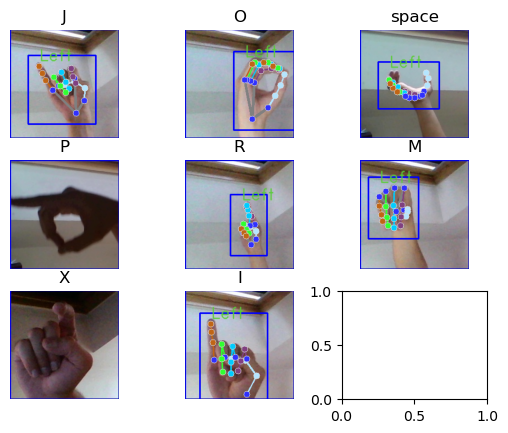

In [828]:
show_images(8, train, 3, 2)

# Pre-Process the Hand Landmark Data

## For each image we have:

### `HandLandmarkerResult`
#### Array of the Left/Right Hand Data
`handedness=[[`
    
    Category(index=float, score=float, display_name=str, category_name=str)]]

To access an image's handedness data and attributes:
`train.handlandmarks[img.idx].handedness[0][0].attribute`

#### Array of Hand Landmark Data:
`hand_landmarks=[[`
        
    NormalizedLandmark(x=float, y=float, z=float, visibility=float, presence=float)

To access an image's hand landmark data coordinates and attributes:
`train.handlandmarks[img.idx].hand_landmarks[0][0].attribute`


## Custom Pre-processing Methods

In [743]:
def ExplodeData(data, explode_cols, data_labels=None):
    data_handlandmarks = data.handlandmarks
    data_img_paths = pd.DataFrame(data.selected_images.items())
    data_img_paths = data_img_paths.explode(1)
    data_img_paths = data_img_paths.rename(columns={1:'img_name'}).drop(columns=[0]).reset_index( drop=True)
    data_frame = pd.DataFrame(data_handlandmarks)
    joined = pd.DataFrame()
    for col in explode_cols:        
        df = pd.json_normalize(data_frame[col])
        df = pd.json_normalize(df[0])
        df = pd.concat([df.drop(columns=[0]), df], axis=1)
        df_list = df[0].tolist()
        df_norm = pd.json_normalize(df_list)
        joined = pd.concat([joined, df_norm], axis=1)
    classes = pd.DataFrame(data_labels)
    joined = pd.concat([joined, classes,data_img_paths], axis=1).dropna()
    joined = joined.reset_index(drop=True).drop('index',axis=1)
    joined = joined.rename(columns={0:'alphabet'})
    return joined

def GetFeaturesAndLabels(dataframe):
    dataframe = pd.get_dummies(dataframe, columns=['category_name'], dtype=int)
    dataframe = dataframe.rename(columns={'category_name_Left':'left', 'category_name_Right':'right'})
    
    cleaned_labels = pd.DataFrame(dataframe['alphabet'])
    cleaned_img_paths = pd.DataFrame(dataframe['img_name'])
    cleaned_features = dataframe.drop(columns=['alphabet','display_name', 'visibility', 'presence', 'img_name'])
    
    cleaned_columns = ['score','x','y','z']
    for column in cleaned_columns: 
        cleaned_features[column] = cleaned_features[column]  / cleaned_features[column].abs().max() 
    
    return cleaned_features, cleaned_labels, cleaned_img_paths

## Pre-process Training and Test Datasets

In [744]:
cleaned_train_features = ExplodeData(train, ['handedness','hand_landmarks'], data_labels = train.labels)
cleaned_train_features, cleaned_train_labels, cleaned_train_img_names = GetFeaturesAndLabels(cleaned_train_features)

cleaned_test_features = ExplodeData(test, ['handedness','hand_landmarks'], data_labels = test.labels)
cleaned_test_features, cleaned_test_labels, cleaned_test_img_names = GetFeaturesAndLabels(cleaned_test_features)

# Create, Compile, & Train the Model


In [745]:
model = Sequential([
    Dense(128, activation='relu'),  # Example hidden layer
    Dense(64, activation='relu'),  # Example hidden layer
    Dense(32, activation='relu'),  # Example hidden layer
    Dense(num_classes, activation='softmax')  # Final layer with softmax activation
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [746]:
model.fit(x=cleaned_train_features, y=cleaned_train_labels, epochs=10, verbose=True, batch_size=3)


Epoch 1/10
69/69 [==============================] - 2s 2ms/step - loss: 3.3690 - accuracy: 0.0583
Epoch 2/10
69/69 [==============================] - 0s 2ms/step - loss: 3.3333 - accuracy: 0.0631
Epoch 3/10
69/69 [==============================] - 0s 2ms/step - loss: 3.2602 - accuracy: 0.0777
Epoch 4/10
69/69 [==============================] - 0s 2ms/step - loss: 3.1098 - accuracy: 0.1068
Epoch 5/10
69/69 [==============================] - 0s 2ms/step - loss: 2.9465 - accuracy: 0.1359
Epoch 6/10
69/69 [==============================] - 0s 2ms/step - loss: 2.8494 - accuracy: 0.1262
Epoch 7/10
69/69 [==============================] - 0s 2ms/step - loss: 2.7419 - accuracy: 0.1117
Epoch 8/10
69/69 [==============================] - 0s 2ms/step - loss: 2.6787 - accuracy: 0.1408
Epoch 9/10
69/69 [==============================] - 0s 2ms/step - loss: 2.6401 - accuracy: 0.1748
Epoch 10/10
69/69 [==============================] - 0s 2ms/step - loss: 2.5987 - accuracy: 0.1845


In [747]:
evaluation = model.evaluate(cleaned_test_features,cleaned_test_labels)

3/3 [==============================] - 0s 3ms/step - loss: 2.6171 - accuracy: 0.2198


In [ ]:
test_predictions = model.predict(cleaned_test_features)

In [832]:
def ShowPredictionResult(test_predictions, idx=random.randint(0, len(test_predictions)-1)):
    prediction_idx = idx
    prediction = test_predictions[prediction_idx]
    true_img_name = cleaned_test_img_names.iloc[prediction_idx].img_name
    true_label = classes[cleaned_test_labels.iloc[prediction_idx].alphabet]
    img = cv2.imread(train_dir + '/' + true_label + '/' + true_img_name)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title("\nThe image file ('{}') is predicted to be alphabet '{}' with a {:.2f}% confidence.\n The true alphabet label for the image is '{}' "
        .format(true_img_name, classes[np.argmax(prediction)], 100 * np.max(prediction), true_label))
    plt.show()


In [835]:
def ShowBatchPredictionsResult(num_imgs, test_predictions, x_axs, y_axs):
    num_imgs = num_imgs
    x_axs = num_imgs//x_axs
    y_axs = y_axs
    fig, ax = plt.subplots(x_axs+1, y_axs+1) 
    x = 0
    y = 0
    for i in range(num_imgs):
        random_img = random.randint(0, len(test_predictions)-1)
        prediction = test_predictions[random_img]
        true_img_name = cleaned_test_img_names.iloc[random_img].img_name
        true_label = classes[cleaned_test_labels.iloc[random_img].alphabet]
        
        img = cv2.imread(train_dir + '/' + true_label + '/' + true_img_name)
        title = ("\nImg File: ('{}') \nPrediction: '{}' \nConf.: {:.2f}%\nTrue Alphabet: '{}'"
            .format(true_img_name, classes[np.argmax(prediction)], 100 * np.max(prediction), true_label))
        ax[x][y].set_title(title)
        ax[x][y].axis('off')
        ax[x][y].imshow(img)

        if y == y_axs:
            y = 0
            x += 1
        else:
            y += 1
    plt.tight_layout()
    plt.show()

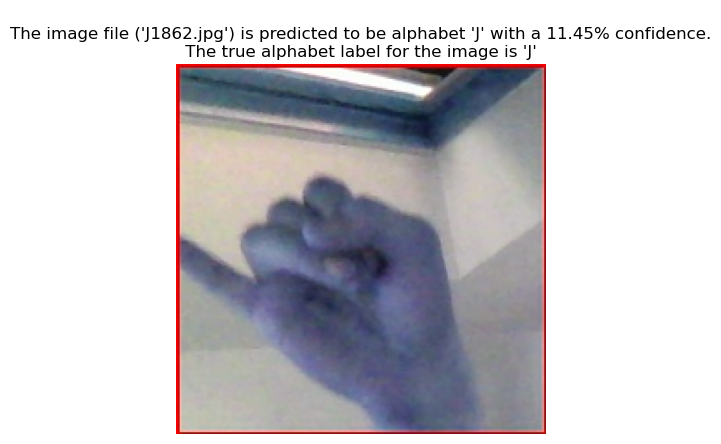

In [836]:
ShowPredictionResult(test_predictions)

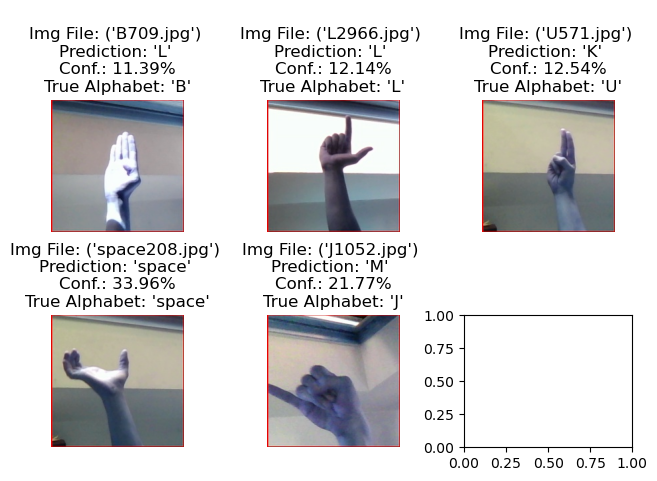

In [837]:
ShowBatchPredictionsResult(5, test_predictions,x_axs=4,y_axs=2)